<a href="https://colab.research.google.com/github/tomowen02/Blogging-social-network/blob/master/FlowerImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import make_grid
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [22]:
image_size = 256
mean = [0.4704, 0.3986, 0.3178]
std = [0.2635, 0.2126, 0.2257]

training_transform = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),
])

testing_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),
])

# Define datasets
training_data = datasets.Flowers102(
    root="/train",
    download=True,
    transform=testing_transform #TODO change to training transformations
)

validation_data = datasets.Flowers102(
    root="/valid",
    download=True,
    transform=testing_transform,
)

test_data = datasets.Flowers102(
    root="/test",
    download=True,
    transform=testing_transform,
)

In [23]:
def get_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    mean = 0
    std = 0
    total_images = 0
    for images, _ in loader:
        image_count_in_batch = images.size(0)
        images = images.view(image_count_in_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += image_count_in_batch
    mean /= total_images
    std /= total_images
    return mean, std

# mean, std = get_mean_std(training_data) # This will only be an approximation of mean and std
# print(f"Mean: {mean}  Std: {std}")

labeles: tensor([70,  1, 30, 74,  8, 90])


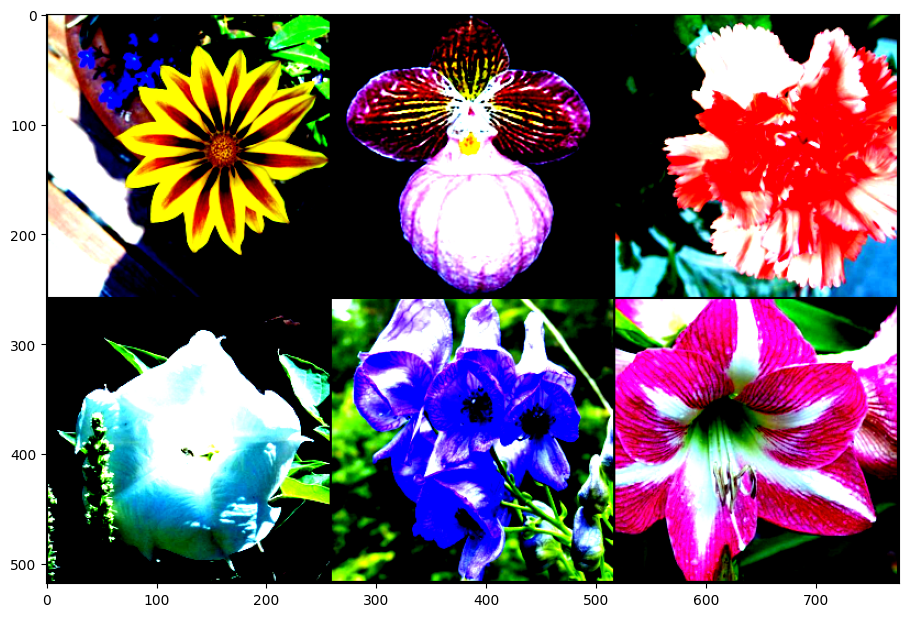

In [24]:
def show_random_images(dataset):
    loader = DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    grid = make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labeles:', labels)

show_random_images(training_data)

In [25]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv_stack = nn.Sequential(
            ## New
            nn.Conv2d(3, 64, 3), # (W-F +2P)/S + 1
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Will reduce the size of the image by a factor of 2
            nn.Conv2d(64, 128, 3), # 125
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 61

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16

            # nn.Conv2d(16, 16, 5), # 125
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2), # 61

            # Temp
            # nn.Linear(3*image_size*image_size, 2**12),
            # nn.ReLU(),
            # nn.Dropout(p=0.5),
            # nn.Linear(4096, 102),
        )
        self.classify = nn.Sequential(
            nn.Linear(256*31*31, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 102),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.classify(x)
        return x

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Linear(in_f

In [26]:
batch_size = 64 #TODO: change to 32?

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
validation_dataloader = DataLoader(validation_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64


In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #TODO: change parameters here

In [28]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [29]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.636835  [   64/ 1020]
Test Error: 
 Accuracy: 1.5%, Avg loss: 4.620393 

Epoch 2
-------------------------------
loss: 4.604145  [   64/ 1020]
Test Error: 
 Accuracy: 6.7%, Avg loss: 4.601218 

Epoch 3
-------------------------------
loss: 4.503108  [   64/ 1020]
Test Error: 
 Accuracy: 7.4%, Avg loss: 4.537046 

Epoch 4
-------------------------------
loss: 4.382974  [   64/ 1020]
Test Error: 
 Accuracy: 11.1%, Avg loss: 4.445889 

Epoch 5
-------------------------------
loss: 4.241159  [   64/ 1020]
Test Error: 
 Accuracy: 18.6%, Avg loss: 4.324179 

Epoch 6
-------------------------------
loss: 4.095859  [   64/ 1020]
Test Error: 
 Accuracy: 22.1%, Avg loss: 4.142437 

Epoch 7
-------------------------------
loss: 3.905853  [   64/ 1020]
Test Error: 
 Accuracy: 27.0%, Avg loss: 3.915571 

Epoch 8
-------------------------------
loss: 3.780765  [   64/ 1020]
Test Error: 
 Accuracy: 36.0%, Avg loss: 3.645155 

Epoch 9
-------------------

In [30]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [31]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>